In [1]:
import numpy as np
import pandas as pd
from IPython.display import display

from scipy.stats import entropy
import os
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import cross_val_score

import ast

import matplotlib.pyplot as plt
%matplotlib inline

### Load the data

In [2]:
dftrain = pd.read_pickle('data_train.p')
dftest = pd.read_pickle('data_test.p')

In [3]:
[col for col in dftrain.columns]

['business_id',
 'date',
 'stars',
 'text',
 'user_id',
 'cos_sim_all',
 'cos_sim_noun',
 'cos_sim_adj',
 'cos_sim_verb',
 'count_review_bus',
 'avg_stars_bus',
 'count_funny_bus',
 'count_cool_bus',
 'count_useful_bus',
 'avg_sent_score_compound_bus',
 'avg_sent_score_net_bus',
 'avg_review_length_bus',
 'avg_punc_count_bus',
 'avg_word_len_bus',
 'count_review_user',
 'avg_stars_user',
 'count_funny_user',
 'count_cool_user',
 'count_useful_user',
 'avg_sent_score_compound_user',
 'avg_sent_score_net_user',
 'avg_review_length_user',
 'avg_punc_count_user',
 'avg_word_len_user',
 'RestaurantsPriceRange2',
 'Alcohol',
 'BusinessAcceptsCreditCards',
 'GoodForKids',
 'OutdoorSeating',
 'RestaurantsAttire',
 'RestaurantsGoodForGroups',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'BikeParking',
 'Caters',
 'DogsAllowed',
 'HasTV',
 'NoiseLevel',
 'RestaurantsDelivery',
 'RestaurantsReservations',
 'WheelchairAccessible',
 'WiFi',
 'CoatCheck',
 'GoodForDancing',
 'HappyHour',
 'Sm

In [4]:
extra_columns = ['business_id', 
                 'date', 
                 'text', 
                 'user_id', 
                 'BestNights',
                 'average_stars',
                 'HairSpecializesIn',
                 'DietaryRestrictions']
dummy_cols = ['NoiseLevel', 'WiFi', 'Smoking', 'AgesAllowed']
target = 'stars'

In [5]:
def data_to_model(raw_data, dummy_cols, extra_columns, normalize_using=None):
    df_X = raw_data.drop(extra_columns + dummy_cols + [target], axis=1)
    if normalize_using is not None:
        df_norm = normalize_using.drop(extra_columns + dummy_cols + [target], axis=1)
    df_y = raw_data[target]
    
    for dummy_col in dummy_cols:
        df_dummy = pd.get_dummies(raw_data[dummy_col], prefix=dummy_col)
        df_X = df_X.join(df_dummy)
        if normalize_using is not None:
            norm_dummy = pd.get_dummies(normalize_using[dummy_col], prefix=dummy_col)
            df_norm = df_norm.join(norm_dummy)
        
    if normalize_using is None:
        df_norm = df_X
        
    normalize(df_X, df_norm)
    return df_X.fillna(0), df_y


def normalize(df_X, normalize_using):
    # memory saving normalization
    for col in df_X.columns:
        # print('normalizing %s' % col)
        norm_mean = np.mean(normalize_using[col].astype(float))
        norm_std = np.std(normalize_using[col].astype(float))
        df_X[col] = (df_X[col].astype(float) - norm_mean) / norm_std
        
        
def mse_loss(preds, truths):
    assert len(preds) == len(truths)
    sse = 0.
    for i in range(len(preds)):
        sse += (preds[i] - truths[i]) ** 2
    return - sse / len(preds)

In [6]:
df_X, df_y = data_to_model(dftrain, dummy_cols, extra_columns, dftrain)
df_Xtest, df_ytest = data_to_model(dftest, dummy_cols, extra_columns, dftrain)

In [7]:
X = df_X.values
y = df_y.values

In [8]:
# filling missing dummies with 0
for col in df_X.columns:
    if col not in df_Xtest.columns:   
        df_Xtest[col] = 0

### Models

### Cross-Validation 

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from time import time



In [10]:
preds_dict_AdaBoost = {"n_estimators": [25, 50, 75],
              "learning_rate": [0.1, 0.5, 1]}
preds_dict_Bagging = {"n_estimators": [5, 10, 20],
              "max_samples": [0.5, 0.75, 1],
              "max_features": [0.5, 0.75, 1]}
preds_dict_ExtraTrees = {"n_estimators": [5, 10, 20],
              "min_samples_split": [2, 4, 6],
              "min_samples_leaf": [1, 2, 3]}
preds_dict_GradientBoosting = {"n_estimators": [50, 100, 150],
              "min_samples_split": [2, 4, 6],
              "min_samples_leaf": [1, 2, 3]}
preds_dict_RandomForest = {"n_estimators": [5, 10, 20],
              "min_samples_split": [2, 4, 6],
              "min_samples_leaf": [1, 2, 3]}

In [11]:
#Hyperparameter search

n_iter_search = 3
random_search_AdaBoost = RandomizedSearchCV(AdaBoostRegressor(), param_distributions=preds_dict_AdaBoost,
                                   n_iter=n_iter_search, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')

start = time()
random_search_AdaBoost.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
random_search_AdaBoost.cv_results_


RandomizedSearchCV took 764.48 seconds for 3 candidates parameter settings.


/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_

{'mean_fit_time': array([171.49739361,  19.59745232,  38.57980371]),
 'std_fit_time': array([66.85814878,  7.52070552, 15.70194981]),
 'mean_score_time': array([0.91712395, 0.11149025, 0.18931524]),
 'std_score_time': array([0.0754889 , 0.01973094, 0.00296155]),
 'param_n_estimators': masked_array(data=[75, 50, 25],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.1, 1, 0.5],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 75, 'learning_rate': 0.1},
  {'n_estimators': 50, 'learning_rate': 1},
  {'n_estimators': 25, 'learning_rate': 0.5}],
 'split0_test_score': array([-1.33226782, -1.33148722, -1.33086199]),
 'split1_test_score': array([-1.39030702, -1.38725095, -1.39216532]),
 'split2_test_score': array([-1.62118476, -1.62288108, -1.6226199 ]),
 'mean_test_score': array([-1.44791986, -1.44720642, -1.44854907]),
 'std_test_s

In [12]:
#Hyperparameter search
n_iter_search = 3
random_search_Bagging = RandomizedSearchCV(BaggingRegressor(), param_distributions=preds_dict_Bagging,
                                   n_iter=n_iter_search, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')

start = time()
random_search_Bagging.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
random_search_Bagging.cv_results_


RandomizedSearchCV took 426.42 seconds for 3 candidates parameter settings.


/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_

{'mean_fit_time': array([56.9209276 ,  3.60829075, 30.04609172]),
 'std_fit_time': array([27.00388248,  1.34874704, 12.77263769]),
 'mean_score_time': array([2.24169707, 1.2686491 , 0.73370155]),
 'std_score_time': array([0.28390299, 0.16714453, 0.02188927]),
 'param_n_estimators': masked_array(data=[20, 10, 5],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_samples': masked_array(data=[0.5, 1, 0.75],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[0.5, 0.75, 0.75],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 20, 'max_samples': 0.5, 'max_features': 0.5},
  {'n_estimators': 10, 'max_samples': 1, 'max_features': 0.75},
  {'n_estimators': 5, 'max_samples': 0.75, 'max_features': 0.75}],
 'split0_test_score': array([-1.38963396, -1.53625857, -1.6094763 ]),
 'split1_tes

In [13]:
#Hyperparameter search
n_iter_search = 3
random_search_ExtraTrees = RandomizedSearchCV(ExtraTreesRegressor(), param_distributions=preds_dict_ExtraTrees,
                                   n_iter=n_iter_search, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')

start = time()
random_search_ExtraTrees.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
random_search_ExtraTrees.cv_results_


RandomizedSearchCV took 670.85 seconds for 3 candidates parameter settings.


/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_

{'mean_fit_time': array([24.82416073, 96.13008229, 26.66192396]),
 'std_fit_time': array([11.42755102, 52.194983  , 12.27902266]),
 'mean_score_time': array([0.16628249, 0.65971502, 0.17438714]),
 'std_score_time': array([0.01597649, 0.15533085, 0.03077672]),
 'param_n_estimators': masked_array(data=[5, 20, 5],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[6, 4, 6],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[2, 2, 1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 2},
  {'n_estimators': 20, 'min_samples_split': 4, 'min_samples_leaf': 2},
  {'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 1}],
 'split0_test_score': array([-1.53434838, -1.38016741, -1.5875688 ]),


In [14]:
#Hyperparameter search
n_iter_search = 3
random_search_GradientBoosting = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=preds_dict_GradientBoosting,
                                   n_iter=n_iter_search, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')

start = time()
random_search_GradientBoosting.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
random_search_GradientBoosting.cv_results_


RandomizedSearchCV took 5636.82 seconds for 3 candidates parameter settings.


/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_

{'mean_fit_time': array([  96.80570912,  156.98418236, 1528.84622065]),
 'std_fit_time': array([  43.38707647,   76.16395569, 2081.50694985]),
 'mean_score_time': array([0.40109022, 0.24688196, 0.15453466]),
 'std_score_time': array([0.32051729, 0.00463419, 0.01965737]),
 'param_n_estimators': masked_array(data=[50, 100, 50],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[2, 6, 4],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[1, 1, 2],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 50,
   'min_samples_split': 2,
   'min_samples_leaf': 1},
  {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1},
  {'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 2}],
 'split0_test_score': array([-1.28817445, -1.2

In [15]:
#Hyperparameter search
n_iter_search = 3
random_search_RandomForest = RandomizedSearchCV(RandomForestRegressor(), param_distributions=preds_dict_RandomForest,
                                   n_iter=n_iter_search, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')

start = time()
random_search_RandomForest.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
random_search_RandomForest.cv_results_


RandomizedSearchCV took 743.90 seconds for 3 candidates parameter settings.


/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_

{'mean_fit_time': array([89.39663061, 43.6453011 , 45.20403552]),
 'std_fit_time': array([43.29044499, 20.51524293, 22.30291662]),
 'mean_score_time': array([0.30574131, 0.14967132, 0.14504997]),
 'std_score_time': array([0.05222438, 0.02316442, 0.0227266 ]),
 'param_n_estimators': masked_array(data=[10, 5, 5],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[4, 6, 6],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[1, 2, 3],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 10,
   'min_samples_split': 4,
   'min_samples_leaf': 1},
  {'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 2},
  {'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 3}],
 'split0_test_score': array([-1.43094211, -1.53026297, -1.521380

#### Check the best parameters

In [51]:
print(random_search_AdaBoost.best_params_)
print(random_search_Bagging.best_params_)
print(random_search_ExtraTrees.best_params_)
print(random_search_GradientBoosting.best_params_)
print(random_search_RandomForest.best_params_)

{'n_estimators': 50, 'learning_rate': 1}
{'n_estimators': 20, 'max_samples': 0.5, 'max_features': 0.5}
{'n_estimators': 20, 'min_samples_split': 4, 'min_samples_leaf': 2}
{'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1}
{'n_estimators': 10, 'min_samples_split': 4, 'min_samples_leaf': 1}


In [67]:
AdaBoostsf.fit(df_X, df_y)
preds_AdaBoost = AdaBoostsf.predict(df_X)
Baggingsf.fit(df_X, df_y)
preds_Bagging = Baggingsf.predict(df_X)
ExtraTreessf.fit(df_X, df_y)
preds_ExtraTrees = ExtraTreessf.predict(df_X)
GradientBoostingsf.fit(df_X, df_y)
preds_GradientBoosting = GradientBoostingsf.predict(df_X)
RandomForestsf.fit(df_X, df_y)
preds_RandomForest = RandomForestsf.predict(df_X)

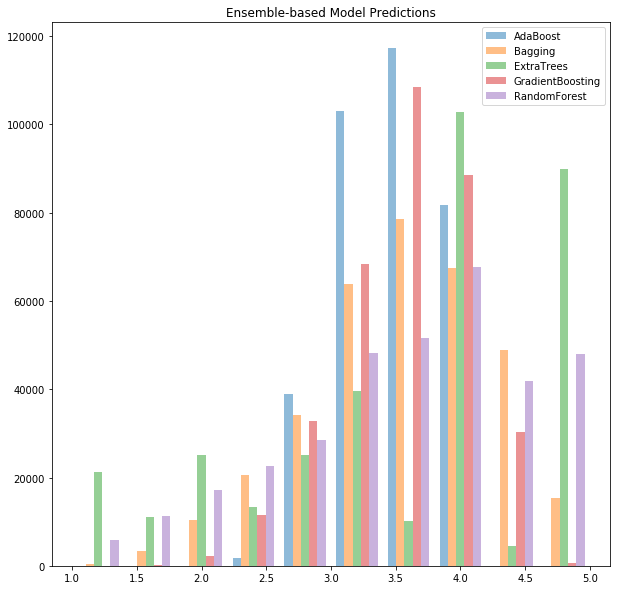

In [69]:
plt.figure(figsize=(10, 10))
plt.hist([preds_AdaBoost, preds_Bagging, preds_ExtraTrees, preds_GradientBoosting, preds_RandomForest], label=['AdaBoost', 'Bagging', 'ExtraTrees', 'GradientBoosting', 'RandomForest'], alpha=0.5)
plt.legend()
plt.title("Ensemble-based Model Predictions")
plt.show()

In [16]:
bestp_AdaBoost = random_search_AdaBoost.best_params_
bestp_Bagging = random_search_Bagging.best_params_
bestp_ExtraTrees = random_search_ExtraTrees.best_params_
bestp_GradientBoosting = random_search_GradientBoosting.best_params_
bestp_RandomForest = random_search_RandomForest.best_params_

AdaBoostsf = AdaBoostRegressor(**bestp_AdaBoost)
scores_AdaBoostsf = cross_val_score(AdaBoostsf, df_X, df_y, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')
np.mean(scores_AdaBoostsf)

-1.4511717500349048

In [17]:
Baggingsf = BaggingRegressor(**bestp_Bagging)
scores_Baggingsf = cross_val_score(Baggingsf, df_X, df_y, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')
np.mean(scores_Baggingsf)

-1.505652986611162

In [18]:
ExtraTreessf = ExtraTreesRegressor(**bestp_ExtraTrees)
scores_ExtraTreessf = cross_val_score(ExtraTreessf, df_X, df_y, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')
np.mean(scores_ExtraTreessf)

-1.4875914030004787

In [19]:
GradientBoostingsf = GradientBoostingRegressor(**bestp_GradientBoosting)
scores_GradientBoostingsf = cross_val_score(GradientBoostingsf, df_X, df_y, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')
np.mean(scores_GradientBoostingsf)

-1.4009447372213717

In [20]:
RandomForestsf = RandomForestRegressor(**bestp_RandomForest)
scores_RandomForestsf = cross_val_score(RandomForestsf, df_X, df_y, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')
np.mean(scores_RandomForestsf)

-1.5520866418543384

### The best model

In [45]:
GradientBoostingsf.fit(df_X, df_y).feature_importances_
GradientBoostingsf.fit(df_X, df_y)
feature_list = [feature for feature in zip(df_X.columns, GradientBoostingsf.feature_importances_)]
feature_list.sort(key=lambda x: x[1], reverse=True)
feature_list = feature_list[:len(feature_list)//2]
feature_selected = [x[0] for x in feature_list]
df_X_selected = df_X[feature_selected]
df_Xtest_selected = df_Xtest[feature_selected]

In [70]:
feature_selected

['avg_stars_bus',
 'avg_stars_user',
 'review_count',
 'avg_sent_score_compound_bus',
 'number of friends',
 'count_review_bus',
 'count_review_user',
 'BikeParking',
 'avg_sent_score_net_bus',
 'street',
 'count_useful_bus',
 'avg_sent_score_net_user',
 'avg_sent_score_compound_user',
 'HasTV',
 'cos_sim_adj',
 'dinesafe_rev_pass',
 'DriveThru',
 'cos_sim_noun',
 'BusinessAcceptsCreditCards',
 'RestaurantsDelivery',
 'avg_word_len_bus',
 'cos_sim_verb',
 'fans',
 'RestaurantsPriceRange2',
 'Caters',
 'casual',
 'count_useful_user',
 'NoiseLevel_quiet',
 'RestaurantsGoodForGroups',
 'NoiseLevel_very_loud',
 'validated',
 'compliment_note',
 'avg_review_length_user',
 'membershiptime',
 'useful',
 'garage',
 'count_cool_bus',
 'DogsAllowed',
 'Alcohol',
 'lunch',
 'dj',
 'RestaurantsTableService',
 'count_funny_bus',
 'lot',
 'valet',
 'dinner',
 'number of years of elite',
 'latenight',
 'OutdoorSeating',
 'avg_punc_count_bus',
 'avg_punc_count_user',
 'CoatCheck',
 'compliment_funny',

In [65]:
# GradientBoostingsf.fit(df_X, df_y)
# y_pred = GradientBoostingsf.predict(df_Xtest)
avg_star = dftest['avg_stars_bus']
np.mean((y_pred - avg_star > 0) == (df_ytest - avg_star > 0))

0.5737397009841977

In [64]:
len(y_pred), len(avg_star)

(79862, 79862)

In [59]:
np.sum((df_ytest - avg_star > 0))

79261

In [ ]:
avg = pd.read_pickle(‘data_val.p’)[‘avg_stars_x’]
np.mean((preds - avg > 0) == (val_y - avg > 0))

In [48]:
# GradientBoostingsf.fit(df_X_selected, df_y)
# y_pred_selected = GradientBoostingsf.predict(df_Xtest_selected)
mean_squared_error(df_ytest, y_pred_selected)

1.4235321327445236

In [34]:
y_pred = GradientBoostingsf.predict(df_Xtest)
mean_squared_error(df_ytest, y_pred)

1.4229663010787161

In [29]:
GradientBoostingsf.score(df_Xtest, df_ytest)

0.1822951449362541

In [8]:
AdaBoost = AdaBoostRegressor().fit(X, y)
Bagging = BaggingRegressor().fit(X, y)
ExtraTrees = ExtraTreesRegressor().fit(X, y)
GradientBoosting = GradientBoostingRegressor().fit(X, y)
RandomForest = RandomForestRegressor().fit(X, y)


/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Validation Data

In [10]:
preds_AdaBoost = AdaBoost.predict(df_Xtest.values)
preds_Bagging = Bagging.predict(df_Xtest.values)
preds_ExtraTrees = ExtraTrees.predict(df_Xtest.values)
preds_GradientBoosting = GradientBoosting.predict(df_Xtest.values)
preds_RandomForest = RandomForest.predict(df_Xtest.values)

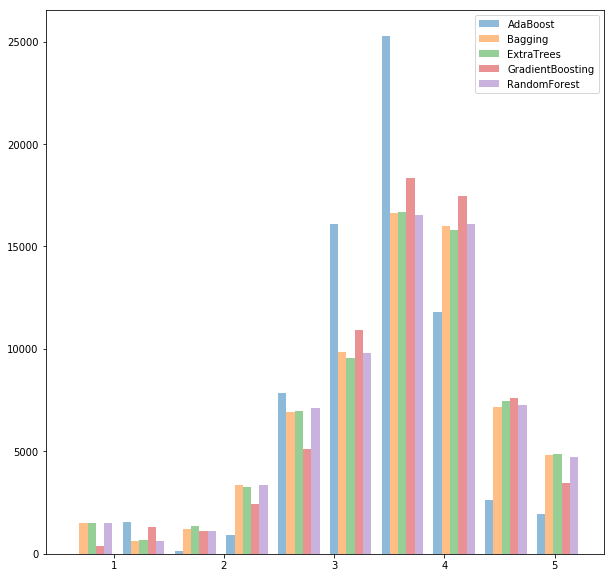

In [11]:
plt.figure(figsize=(10, 10))
plt.hist([preds_AdaBoost, preds_Bagging, preds_ExtraTrees, preds_GradientBoosting, preds_RandomForest], label=['AdaBoost', 'Bagging', 'ExtraTrees', 'GradientBoosting', 'RandomForest'], alpha=0.5)
# plt.hist(preds_lin, label='Linear Regression', alpha=0.5)
plt.legend()
plt.show()

### Scoring

In [12]:
display(AdaBoost.score(df_Xtest, df_ytest))
display(Bagging.score(df_Xtest, df_ytest))
display(ExtraTrees.score(df_Xtest, df_ytest))
display(GradientBoosting.score(df_Xtest, df_ytest))
display(RandomForest.score(df_Xtest, df_ytest))

0.32108752681356817

0.3188352833248893

0.3148015671469643

0.39094182573012215

0.32003219601951227

In [13]:
display(mse_loss(preds_AdaBoost, df_ytest))
display(mse_loss(preds_Bagging, df_ytest))
display(mse_loss(preds_ExtraTrees, df_ytest))
display(mse_loss(preds_GradientBoosting, df_ytest))
display(mse_loss(preds_RandomForest, df_ytest))

-1.2005156720921883

-1.2044982968226983

-1.211631085922358

-1.0769928559348736

-1.2023818053679425

### What happens if we drop the average rating field of the restaurant and the user?

In [14]:
extra_columnsx = ['business_id', 
                 'date', 
                 'text', 
                 'user_id', 
                 'BestNights',
                 'HairSpecializesIn',
                 'DietaryRestrictions',
                 'avg_stars_bus',
                 'avg_stars_user',
                 'average_stars']
dummy_colsx = ['NoiseLevel', 'WiFi', 'Smoking', 'AgesAllowed']
targetx = 'stars'

In [15]:
df_Xx, df_yx = data_to_model(dftrain, dummy_colsx, extra_columnsx, dftrain)
#df_Xvalx, df_yvalx = data_to_model(dfval, dummy_colsx, extra_columnsx, dftrain)
df_Xtestx, df_ytestx = data_to_model(dftest, dummy_colsx, extra_columnsx, dftrain)

In [16]:
Xx = df_Xx.values
yx = df_yx.values

In [18]:
AdaBoost_x = AdaBoostRegressor().fit(Xx, yx)
Bagging_x = BaggingRegressor().fit(Xx, yx)
ExtraTrees_x = ExtraTreesRegressor().fit(Xx, yx)
GradientBoosting_x = GradientBoostingRegressor().fit(Xx, yx)
RandomForest_x = RandomForestRegressor().fit(Xx, yx)


/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/BingZou/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [22]:
# filling missing dummies with 0
for col in df_Xx.columns:
    if col not in df_Xtestx.columns:
        df_Xtestx[col] = 0

In [23]:
# preds_AdaBoost_x = AdaBoost_x.predict(df_Xtestx.values)
# preds_Bagging_x = Bagging_x.predict(df_Xtestx.values)
# preds_ExtraTrees_x = ExtraTrees_x.predict(df_Xtestx.values)
# preds_GradientBoosting_x = GradientBoosting_x.predict(df_Xtestx.values)
# preds_RandomForest_x = RandomForest_x.predict(df_Xtestx.values)


### Scoring

In [28]:
# display(AdaBoost_x.score(df_Xvalx, df_yvalx))
# display(Bagging_x.score(df_Xvalx, df_yvalx))
# display(ExtraTrees_x.score(df_Xvalx, df_yvalx))
# display(GradientBoosting_x.score(df_Xvalx, df_yvalx))
# display(RandomForest_x.score(df_Xvalx, df_yvalx))

0.08965803394237326

0.048112916086501485

0.01984379365358424

0.1449236059799589

0.05181628768200841

In [29]:
# display(mse_loss(preds_AdaBoost_x, df_yvalx))
# display(mse_loss(preds_Bagging_x, df_yvalx))
# display(mse_loss(preds_ExtraTrees_x, df_yvalx))
# display(mse_loss(preds_GradientBoosting_x, df_yvalx))
# display(mse_loss(preds_RandomForest_x, df_yvalx))

-1.6097506532556483

-1.6832145636342832

-1.7332026340518605

-1.512024969933458

-1.6766659203030876

### What is baseline random?

In [30]:
# len(df_yval)

68108

In [31]:
# df_yval.unique()

array([5, 4, 3, 2, 1])

In [33]:
# from tqdm import tqdm_notebook as tqdm

# rand_mses = []

# for i in tqdm(range(100)):
#     rand_vals = np.random.randint(1, 6, len(df_yval))
#     rand_mse = mse_loss(rand_vals, df_yval)
#     rand_mses.append(rand_mse)

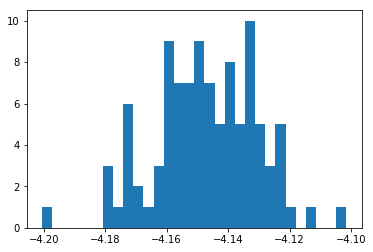

In [34]:
# plt.hist(rand_mses, bins=30)
# plt.show()

### Baseline MSE = 4.15

In [35]:
# np.mean(rand_mses)

-4.14713924942738